In [73]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation

import gc

np.random.seed(1234)

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce GTX 1650


In [68]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [5]:
lbfgs_lr = 0.001
adam_lr = 0.001

w_pde = 1.0
w_bc = 1.0
w_ic = 1.0

In [84]:
class PINN():
    def __init__(self, x, t, points, layers, f, ic1, ic2):

        self.x = x
        self.t = t

        self.points = points

        self.f = f
        self.ic1 = ic1
        self.ic2 = ic2

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=1000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, t):
        out = self.dnn(torch.cat((x, t), dim=1))
        u = out[:,0].view(-1, 1)
        m = out[:,1].view(-1, 1)
        return u, m
    
    def space_derivative(self, u, m, x):
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]      

        return u_x, u_2x, m_x, m_2x
    
    def time_derivative(self, u , t):
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_2t = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]
        return u_t, u_2t

    def bc_loss(self, u, m):
        bc_loss = torch.mean(u**2) + torch.mean(m**2)
        return bc_loss
    
    def ic_loss(self, u, u_t):
        ic_loss = torch.mean((u - self.ic1)**2)
        ic_loss += torch.mean((u_t - self.ic2)**2)
        return ic_loss

    def pde_loss(self, m_2x, u_2t):        
        pde_loss = torch.mean((u_2t + m_2x - self.f)**2)
        return pde_loss

    def loss_func(self):
        u, m = self.model_value(self.x, self.t)
        _, _, _, m_2x = self.space_derivative(u, m, self.x)
        u_t, u_2t = self.time_derivative(u, self.t)

        split_tensors = [torch.split(tensor, self.points) for tensor in (u, m, u_t, u_2t, m_2x)]

        (_, u_lbc, u_rbc, u_ic), (_, m_lbc, m_rbc, _), (_, _, _, ut_ic), (u2t_d, _, _, _), (m2x_d, _, _, _) = split_tensors
        
        pde_loss = self.pde_loss(m2x_d, u2t_d)
        bc_loss = self.bc_loss(u_lbc, m_lbc)
        bc_loss = self.bc_loss(u_rbc, m_rbc)
        ic_loss = self.ic_loss(u_ic, ut_ic)  

        return pde_loss, bc_loss, ic_loss


    def lbfgs_func(self):
        pde_loss, bc_loss, ic_loss = self.loss_func()
        loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss, ic_loss = self.loss_func()
            loss = w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            # self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}, IC: {'{:e}'.format(ic_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)
        torch.cuda.synchronize()  


    def predict(self, x, t):
        x = torch.tensor(x).float().to(device)
        t = torch.tensor(t).float().to(device)

        self.dnn.eval()
        u, _ = self.model_value(x, t)
        u = u.detach().cpu().numpy()
        return u

In [63]:
def func(x, t):
    return (1-16*np.pi**2) * np.sin(x) * np.cos(4*np.pi*t)

In [64]:
def generate_points(points):
    x_d = torch.rand((points[0], 1), device=device) * torch.pi
    t_d = torch.rand((points[0], 1), device=device)

    x_lbc = torch.zeros((points[1], 1), device=device)
    t_lbc = torch.rand((points[1], 1), device=device)

    x_rbc = torch.ones((points[2], 1), device=device) * torch.pi
    t_rbc = torch.rand((points[2], 1), device=device)

    x_ic = torch.rand((points[3], 1), device=device) * torch.pi
    t_ic = torch.zeros((points[3], 1), device=device)
    # Functions
    f = lambda x, t: (1 - 16*torch.pi**2)*torch.sin(x)*torch.cos(4*torch.pi*t)
    ic1 = lambda x: torch.sin(x)
    ic2 = lambda x: torch.full_like(x, 0)   

    vec1 = ic1(x_ic)
    vec2 = ic2(x_ic)
    fun = f(x_d, t_d)

    x_comb = torch.cat([x_d, x_lbc, x_rbc, x_ic]).requires_grad_()
    t_comb = torch.cat([t_d, t_lbc, t_rbc, t_ic]).requires_grad_()
    return x_comb, t_comb, vec1, vec2, fun

In [97]:
points = [10000, 2000, 2000, 2000]
x_comb, t_comb, vec1, vec2, fun = generate_points(points)
# x_d, x_lbc, x_rbc, x_ic = torch.split(x_comb, points)


In [86]:
nodes = 64
layers = [2, nodes, nodes, nodes, nodes, 2]

model = PINN(x_comb, t_comb, points, layers, fun, vec1, vec2)

In [98]:
model.x = x_comb
model.t = t_comb
model.points = points
model.f = fun
model.ic1 = vec1
model.ic2 = vec2

In [99]:
%%time

model.train(3000)

Epoch 0, Loss: 7.630437e-01
PDE: 7.394492e-01, BC: 5.656525e-03, IC: 1.793795e-02
Epoch 100, Loss: 5.218252e-01
PDE: 4.958751e-01, BC: 5.562657e-03, IC: 2.038739e-02
Epoch 200, Loss: 4.664428e-01
PDE: 4.425551e-01, BC: 4.984982e-03, IC: 1.890270e-02
Epoch 300, Loss: 4.274778e-01
PDE: 4.051334e-01, BC: 4.549124e-03, IC: 1.779525e-02
Epoch 400, Loss: 4.248448e-01
PDE: 4.036738e-01, BC: 4.472575e-03, IC: 1.669844e-02
Epoch 500, Loss: 3.747960e-01
PDE: 3.550398e-01, BC: 4.138825e-03, IC: 1.561730e-02
Epoch 600, Loss: 1.606289e+01
PDE: 1.593762e+01, BC: 4.006208e-03, IC: 1.212638e-01
Epoch 700, Loss: 3.361557e-01
PDE: 3.182441e-01, BC: 3.912978e-03, IC: 1.399868e-02
Epoch 800, Loss: 3.136211e-01
PDE: 2.965662e-01, BC: 3.688833e-03, IC: 1.336613e-02
Epoch 900, Loss: 1.140190e+00
PDE: 1.116282e+00, BC: 3.890328e-03, IC: 2.001724e-02
Epoch 1000, Loss: 2.844451e-01
PDE: 2.688200e-01, BC: 3.558354e-03, IC: 1.206667e-02
Epoch 1100, Loss: 2.679034e-01
PDE: 2.529207e-01, BC: 3.386942e-03, IC: 1.159

In [ ]:
# torch.save(model.dnn.state_dict(), "time_model_weights.pth")

In [74]:
del model
gc.collect()
torch.cuda.empty_cache()

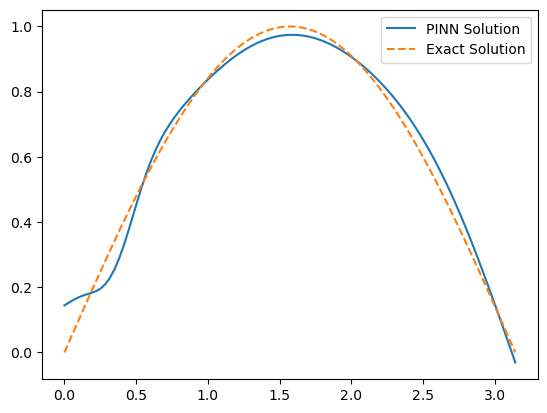

In [100]:

x = np.linspace(0, torch.pi, 100).reshape(-1, 1)
t = np.zeros(100).reshape(-1, 1)

y = np.sin(x)

u = model.predict(x, t)
plt.plot(x, u, label="PINN Solution")
plt.plot(x, y, label="Exact Solution", linestyle="dashed")
plt.legend()

In [101]:
# Define the resolution of the grid
x_min, x_max = 0, np.pi  # X range
t_min, t_max = 0, 1  # Time range
grid_size = 100  # Number of points in each dimension

# Create a meshgrid
x_vals = np.linspace(x_min, x_max, grid_size)
t_vals = np.linspace(t_min, t_max, grid_size)
X, T = np.meshgrid(x_vals, t_vals)  # Create a 2D meshgrid

# Flatten the meshgrid and convert to PyTorch tensor
X_flat = X.flatten().reshape(-1, 1)
T_flat = T.flatten().reshape(-1, 1)

u_exact = np.sin(X_flat) * np.cos(4 * torch.pi * T_flat)
u_pred = model.predict(X_flat, T_flat)

abs_error = np.abs(u_pred - u_exact)
l2_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact, 2)

u_pred = u_pred.reshape(grid_size, grid_size)
u_exact = u_exact.reshape(grid_size, grid_size)
abs_error = abs_error.reshape(grid_size, grid_size)

print(l2_error)

0.5780148129415255


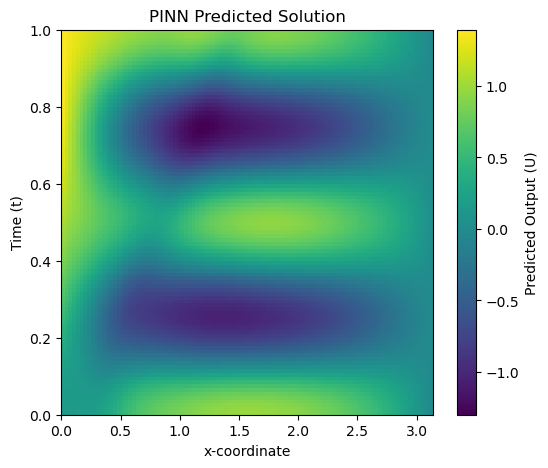

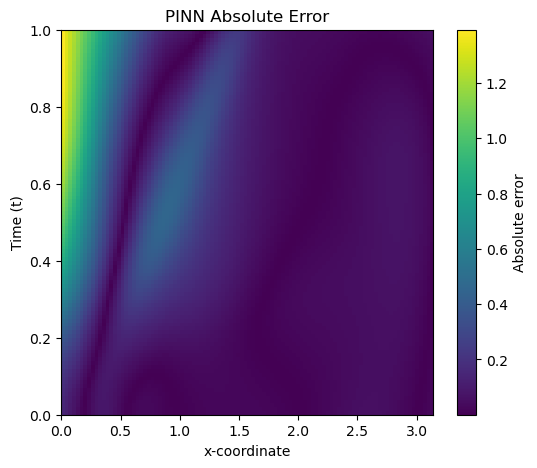

In [102]:

plt.figure(figsize=(6, 5))
plt.imshow(u_pred, extent=[x_min, x_max, t_min, t_max], origin="lower", aspect="auto")
plt.colorbar(label="Predicted Output (U)")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Predicted Solution")


plt.figure(figsize=(6, 5))
plt.imshow(abs_error, extent=[x_min, x_max, t_min, t_max], origin="lower", aspect="auto")
plt.colorbar(label="Absolute error")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Absolute Error")

plt.show()